# An introduction to `relatio` 
**Runtime $\sim$ 5min**

Original paper: ["Text Semantics Capture Political and Economic Narratives"](https://arxiv.org/abs/2108.01720)

----------------------------

This is a short demo of the package `relatio`.  It takes as input a text corpus and outputs a list of narrative statements. The pipeline is unsupervised: the user does not need to specify narratives beforehand. Narrative statements are defined as tuples of semantic roles with a (agent, verb, patient, attribute) structure. 

Here, we present the main wrapper functions to quickly obtain narrative statements from a corpus.

----------------------------

In this tutorial, we work with the Trump Tweet Archive corpus.

----------------------------

In [ ]:
# Catch warnings for an easy ride
from relatio import FileLogger
logger = FileLogger(level = 'WARNING')

In [ ]:
from relatio import load_data
df = load_data(dataset = "trump_tweet_archive", content = "raw")
df.head()

In [ ]:
from relatio import Preprocessor

import spacy
nlp = spacy.load('en_core_web_md')
stop_words = list(nlp.Defaults.stop_words)

p = Preprocessor(
    spacy_model = "en_core_web_sm",
    remove_punctuation = True,
    remove_digits = True,
    lowercase = True,
    lemmatize = True,
    remove_chars = ["\"",'-',"^",".","?","!",";","(",")",",",":","\'","+","&","|","/","{","}",
                    "~","_","`","[","]",">","<","=","*","%","$","@","#","’"],
    stop_words = stop_words,
    n_process = -1,
    batch_size = 100
)

doc_index, sentences = p.split_into_sentences(
    df, output_path = None, progress_bar = True
)

In [ ]:
from relatio import SRL

SRL = SRL(
    path = "https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz",
    batch_size = 10,
    cuda_device = -1
)

srl_res = SRL(sentences[0:100], progress_bar=True)

In [1]:
from relatio import load_data
srl_res = load_data('trump_tweet_archive', 'srl_res')

/home/germain/Desktop/relatio/.tox/dev/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/germain/Desktop/relatio/.tox/dev/lib/python3.7/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
from relatio import extract_roles

roles, sentence_index = extract_roles(
    srl_res, 
    used_roles = ["ARG0","B-V","B-ARGM-NEG","B-ARGM-MOD","ARG1","ARG2"],
    progress_bar = True
)

for d in roles[0:5]: print(d)

In [ ]:
postproc_roles = p.process_roles(roles, 
                                 dict_of_pos_tags_to_keep = {
                                     "ARG0": ['PRON', 'NOUN', 'PROPN'],
                                     "B-V": ['VERB'],
                                     "ARG1": ['NOUN', 'PROPN', 'PRON']
                                 }, 
                                 max_length = 50,
                                 progress_bar = True,
                                 output_path = 'postproc_roles.json')

for d in postproc_roles[0:5]: print(d)

In [2]:
from relatio.utils import load_roles
postproc_roles = load_roles('postproc_roles.json')

In [ ]:
known_entities = p.mine_entities(
    sentences, 
    clean_entities = True, 
    progress_bar = True,
    output_path = 'entities.pkl'
)

for n in known_entities.most_common(10): print(n)

In [3]:
from relatio.utils import load_entities
known_entities = load_entities('entities.pkl')

top_known_entities = [e[0] for e in list(known_entities.most_common(100)) if e[0] != '']

In [4]:
from relatio.narrative_models import NarrativeModel

m = NarrativeModel(
    model_type = 'kmeans', #hdbscan, kmeans, or deterministic
    roles_considered = ['ARG0', 'B-V', 'B-ARGM-NEG', 'ARG1', 'ARG2'],
    roles_with_known_entities = ['ARG0','ARG1','ARG2'],
    known_entities = top_known_entities,
    assignment_to_known_entities = 'character_matching',
    roles_with_unknown_entities = ['ARG0','ARG1','ARG2'],
    threshold = 0.3
)    
             
m.fit(postproc_roles, progress_bar = True) # pca_args, umap_args, and cluster_args give compete control to the user

2022-07-08 11:17:39.775950: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-07-08 11:17:39.775986: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: germain-XPS-15-9500
2022-07-08 11:17:39.775993: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: germain-XPS-15-9500
2022-07-08 11:17:39.776138: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-07-08 11:17:39.776162: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-07-08 11:17:39.776167: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 510.47.3 does not match DSO version 510.73.5 -- cannot find working devices in this configuration
2022-07-08 11:17:39.776620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neura

Matching known entities (with character matching)...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7952/7952 [00:00<00:00, 16173.26it/s]


Matching known entities (with character matching)...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25162/25162 [00:01<00:00, 14747.38it/s]


Matching known entities (with character matching)...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15228/15228 [00:00<00:00, 15350.24it/s]


Computing phrase embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30050/30050 [00:48<00:00, 624.21it/s]


Dimension reduction via PCA + UMAP...
PCA parameters:
{'n_components': 50, 'svd_solver': 'full'}
UMAP parameters:
{'n_neighbors': 15, 'n_components': 2, 'random_state': 0}
Clustering phrases into clusters...
Clustering parameters chosen in this range:
{'n_clusters': [29, 74, 149, 224, 300], 'random_state': 0}
Labeling the clusters by the most frequent phrases...


/home/germain/Desktop/relatio/relatio/narrative_models.py:449: RuntimeWarning: Multiple labels for cluster 2- 2 shown: [('omarosa', 33), ('rosie', 33)]. First one is picked.
  RuntimeWarning,
/home/germain/Desktop/relatio/relatio/narrative_models.py:449: RuntimeWarning: Multiple labels for cluster 20- 2 shown: [('conflict', 12), ('defeat', 12)]. First one is picked.
  RuntimeWarning,
/home/germain/Desktop/relatio/relatio/narrative_models.py:449: RuntimeWarning: Multiple labels for cluster 37- 2 shown: [('issue', 22), ('solution', 22)]. First one is picked.
  RuntimeWarning,
/home/germain/Desktop/relatio/relatio/narrative_models.py:449: RuntimeWarning: Multiple labels for cluster 53- 2 shown: [('colorado', 13), ('indiana', 13)]. First one is picked.
  RuntimeWarning,
/home/germain/Desktop/relatio/relatio/narrative_models.py:449: RuntimeWarning: Multiple labels for cluster 65- 2 shown: [('friend president xi', 4), ('president moon south korea', 4)]. First one is picked.
  RuntimeWarning,

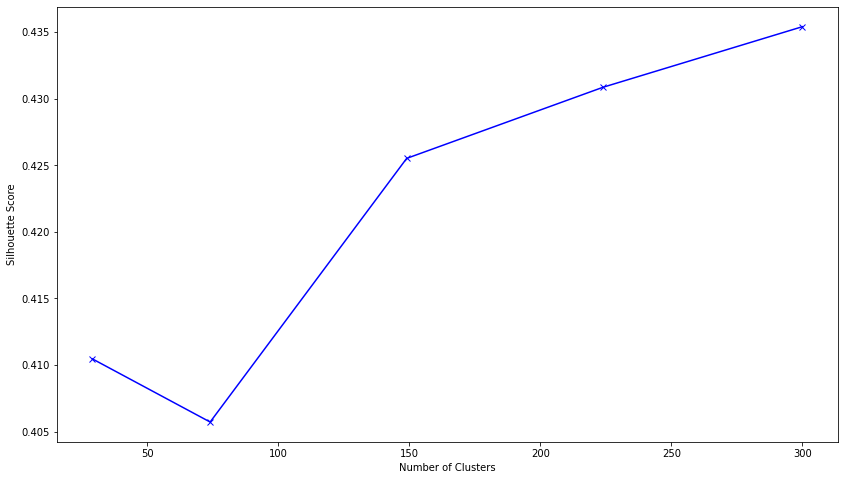

In [5]:
if m.model_type == 'kmeans':
    m.plot_selection_metric() # only for kmeans 

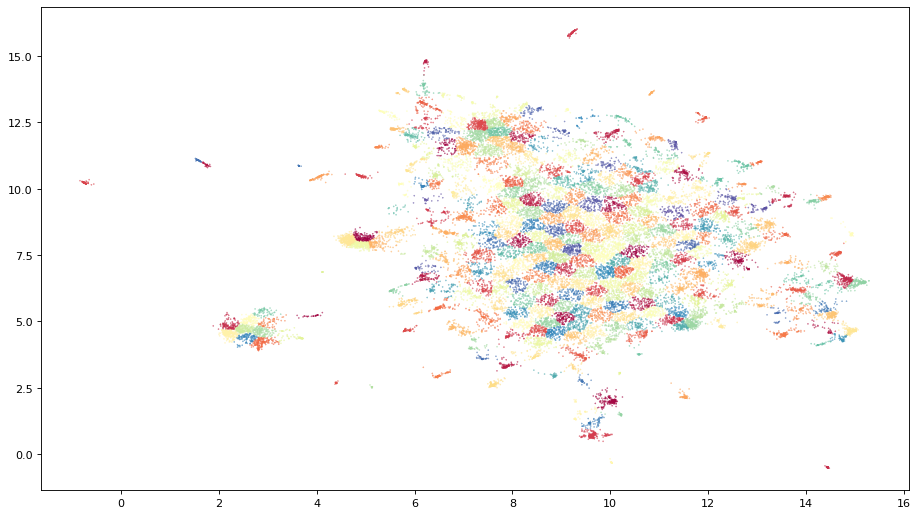

In [6]:
if m.umap_args['n_components'] == 2:
    m.plot_clusters('clusters.pdf') # only for UMAP with 2 components (the default)

In [7]:
m.labels_unknown_entities

{0: 'foxnew',
 1: 'control',
 2: 'omarosa',
 3: 'lobbyist',
 4: 'crime',
 5: 'work',
 6: 'mess',
 7: 'gold',
 8: 'ventilator',
 9: 'government',
 10: 'rigged election',
 11: 'way',
 12: 'letterman',
 13: 'terrorist',
 14: 'impeachment hoax',
 15: 'corruption',
 16: 'schiff',
 17: 'city',
 18: 'police',
 19: 'oval office',
 20: 'conflict',
 21: 'tariff',
 22: 'amp family',
 23: 'james comey',
 24: 'heart',
 25: 'good',
 26: 'business',
 27: 'loser',
 28: 'interview',
 29: 'russians',
 30: 'immigration',
 31: 'john mccain',
 32: 'time',
 33: 'golf',
 34: 'taxis',
 35: 'warming',
 36: 'twitter',
 37: 'issue',
 38: 'matt',
 39: 'ebola',
 40: 'nfl',
 41: 'joke',
 42: 'family',
 43: 'jeb bush',
 44: 'success',
 45: 'billion dollar',
 46: 'soldier',
 47: 'hoax',
 48: 'debate',
 49: 'poll number',
 50: 'strong',
 51: 'wind turbine',
 52: 'senator',
 53: 'colorado',
 54: 'race',
 55: 'unemployment',
 56: 'dollar',
 57: 'word',
 58: 'haters amp loser',
 59: 'hurricane',
 60: 'company',
 61: 'sou

In [8]:
m.inspect_cluster(label = 'radical left')

[('radical left', 45),
 ('radical', 8),
 ('radical islamic terrorism', 6),
 ('radical islam', 4),
 ('radical left congresswomen', 4),
 ('war radical islamic terrorists', 3),
 ('funding radical ideology', 2),
 ('radical islamic terrorists', 2),
 ('radical left crazy', 2),
 ('radical left crime cancel culture', 2)]

In [9]:
m.clusters_to_txt()

In [10]:
narratives = m.predict(postproc_roles, progress_bar = True)


Predicting entities for role: ARG0...
Matching known entities (with character matching)...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24368/24368 [00:01<00:00, 15013.47it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24368/24368 [00:40<00:00, 602.93it/s]


Dimension reduction of vectors (PCA + UMAP)...
Assignment to clusters...
Assigning labels to matches...

Predicting entities for role: ARG1...
Matching known entities (with character matching)...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61012/61012 [00:03<00:00, 15754.23it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61012/61012 [01:46<00:00, 572.22it/s]


Dimension reduction of vectors (PCA + UMAP)...
Assignment to clusters...
Assigning labels to matches...

Predicting entities for role: ARG2...
Matching known entities (with character matching)...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26776/26776 [00:01<00:00, 15630.68it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26776/26776 [00:42<00:00, 635.24it/s]


Dimension reduction of vectors (PCA + UMAP)...
Assignment to clusters...
Assigning labels to matches...


In [11]:
from relatio.utils import prettify
from collections import Counter

pretty_narratives = []
for n in narratives: 
    if n.get('ARG0') is not None:
        if n.get('B-V') is not None:
            if n.get('ARG1') is not None:
                pretty_narratives.append(prettify(n))
                
pretty_narratives = Counter(pretty_narratives)
for t in pretty_narratives.most_common(10): print(t)

('china want deal', 8)
('economy hit work', 7)
('democrats want open borders', 7)
('china steal job', 7)
('interview discuss mittromney', 6)
('fortune kill country', 6)
('democrats steal election', 5)
('interview discuss barackobama|mittromney', 5)
('success breed success', 5)
('u s lose billion dollar', 5)


In [12]:
from relatio import build_graph, draw_graph

G = build_graph(
    narratives, 
    top_n = 100, 
    prune_network = True
)

draw_graph(
    G,
    notebook = False,
    show_buttons = False,
    width="1600px",
    height="1000px",
    output_filename = 'network_of_narratives.html'
    )